## Installing Dependencies

In [1]:
!pip install googlemaps
!pip install flask
!pip install pyspark

  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40712 sha256=f0365a27ba37334df92570eed9a709f6a2cb2df4026a5115a0991c92bca554cd
  Stored in directory: /root/.cache/pip/wheels/17/f8/79/999d5d37118fd35d7219ef57933eb9d09886c4c4503a800f84
Successfully built googlemaps
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=6329e18f0aa18d637f371c2a227c497daa4fb7a9c5974e5205a7555df096c605
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


## Setting up Spark

In [2]:
import os
import pyspark

conf = pyspark.SparkConf()
conf.set('spark.sql.repl.eagerEval.enabled', True) # enabled for debuggig
conf.set('spark.driver.memory','12g')
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Importing Dependencies

In [3]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit, count, avg, sum, udf, round, floor
from pyspark.sql.types import IntegerType, DateType, StructType, StructField, DoubleType, StringType
from itertools import product
import requests
import googlemaps
import json
from flask import Flask, request, jsonify
from googlemaps.maps import StaticMapPath
from googlemaps.maps import StaticMapMarker
import cv2
from matplotlib import pyplot as plt
# from IPython.display import Image

## Reading the CSV data into a Spark DataFrame

### Adding an offense severity column and formatting the date column properly

In [4]:
arrest_data_df = spark.read.option("header", "true").csv("data.csv")

# Properly formatting the arrest date column
arrest_data_df = arrest_data_df.withColumn("ARREST_DATE", to_date(arrest_data_df["ARREST_DATE"], "MM/dd/yyyy").cast(DateType()))

# Assigning an offense severity value of 5 to felonies, 3 to misdemeanors and 1 to violations
arrest_data_df = arrest_data_df.withColumn('OFNS_SVRT', when(col('LAW_CAT_CD') == 'F', 5) \
                                           .when(col('LAW_CAT_CD') == 'M', 3) \
                                           .otherwise(1))

# Dropping unnecessary columns from the dataframe
arrest_data_df = arrest_data_df \
    .select(col("ARREST_DATE"), col("ARREST_BORO"), col("AGE_GROUP"), col("PERP_SEX"), col("PERP_RACE"), col("Latitude"), col("Longitude"), col("OFNS_SVRT"))

# Dropping nulls
arrest_data_df = arrest_data_df.dropna()

### Printing the record count and data snapshot

In [5]:
print(arrest_data_df.count())
arrest_data_df

5725496


ARREST_DATE,ARREST_BORO,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,OFNS_SVRT
2020-11-19,B,18-24,M,BLACK,40.816391847000034,-73.89529641399997,5
2020-12-18,K,45-64,M,WHITE,40.69546894100006,-73.98282507899995,5
2020-12-09,S,<18,M,BLACK,40.64472613100002,-74.07748315899995,5
2020-09-15,B,25-44,M,BLACK,40.83995593800007,-73.90906496999997,3
2020-10-21,Q,25-44,M,WHITE HISPANIC,40.72236368700004,-73.85147389399998,5
2020-09-21,K,25-44,M,BLACK,40.67458330800008,-73.93022154099998,5
2018-02-08,M,25-44,M,BLACK,40.765397475000036,-73.98570226399994,5
2020-07-07,B,25-44,M,BLACK,40.816391847000034,-73.89529641399997,5
2020-07-20,S,<18,M,WHITE,40.51158633800003,-74.24930372699998,5
2020-08-31,K,18-24,M,BLACK,40.67458330800008,-73.93022154099998,5


## Computing the zone id using the latitude and longitude values

### Setting the geographical boundaries for NYC to create zones

In [6]:
# Defining the boundaries for NYC
min_latitude, max_latitude = 40.49, 62.08
min_longitude, max_longitude = -74.26, -73.68

# Number of divisions along each axis to create 25,000,000 zones (5000x5000)
num_divisions = 5000

lat_step = (max_latitude - min_latitude) / num_divisions
lon_step = (max_longitude - min_longitude) / num_divisions

### Writing a user-defined function to aid our computations

In [7]:
def find_zone_id(latitude, longitude):
    # Input validation
    if not (min_latitude <= latitude <= max_latitude) or not (min_longitude <= longitude <= max_longitude):
        return "Invalid latitude or longitude"

    # Calculate indexes
    lat_index = int((latitude - min_latitude) / lat_step)
    lon_index = int((longitude - min_longitude) / lon_step)

    # Handle edge cases
    if lat_index == num_divisions:
        lat_index -= 1
    if lon_index == num_divisions:
        lon_index -= 1

    # Calculate zone_id
    zone_id = lat_index * num_divisions + lon_index
    return zone_id

find_zone_id_udf = udf(find_zone_id, IntegerType())

### Adding the newly computed zone id to the dataframe

In [8]:
# Create a new dataframe and round the latitude and longitude to 6 decimal places
new_df = arrest_data_df.withColumn("Latitude", round(col("Latitude"), 6)) \
                      .withColumn("Longitude", round(col("Longitude"), 6))


# Update new_df to include the zone_id using the UDF we wrote earlier
new_df_with_zone_id = new_df.withColumn('zone_id', find_zone_id_udf(col("Latitude"), col("Longitude")))

# Show the updated DataFrame or process further
new_df_with_zone_id.show(10)

+-----------+-----------+---------+--------+--------------+---------+----------+---------+-------+
|ARREST_DATE|ARREST_BORO|AGE_GROUP|PERP_SEX|     PERP_RACE| Latitude| Longitude|OFNS_SVRT|zone_id|
+-----------+-----------+---------+--------+--------------+---------+----------+---------+-------+
| 2020-11-19|          B|    18-24|       M|         BLACK|40.816392|-73.895296|        5| 378144|
| 2020-12-18|          K|    45-64|       M|         WHITE|40.695469|-73.982825|        5| 237389|
| 2020-12-09|          S|      <18|       M|         BLACK|40.644726|-74.077483|        5| 176573|
| 2020-09-15|          B|    25-44|       M|         BLACK|40.839956|-73.909065|        3| 408025|
| 2020-10-21|          Q|    25-44|       M|WHITE HISPANIC|40.722364|-73.851474|        5| 268521|
| 2020-09-21|          K|    25-44|       M|         BLACK|40.674583|-73.930222|        5| 212842|
| 2018-02-08|          M|    25-44|       M|         BLACK|40.765397|-73.985702|        5| 317364|
| 2020-07-

## Calculating the risk score for each zone

### Using offense severity associated with each arrest to calculate the risk score for each zone

In [9]:
# Calculate the total daily risk score per zone on each arrest date
daily_risk_score_by_zone = new_df_with_zone_id.groupBy("zone_id", "ARREST_DATE").agg(sum("OFNS_SVRT").alias("daily_risk"))

# Calculate the average daily risk score for each zone
risk_score_by_zone = daily_risk_score_by_zone.groupBy("zone_id").agg(avg("daily_risk").alias("zone_risk_score"))
risk_score_by_zone.dropna()

zone_id,zone_risk_score
382774,4.448637316561845
132406,4.107142857142857
438279,5.0717522658610275
342674,4.657894736842105
218049,4.692982456140351
232473,4.225
307982,3.627906976744186
172959,4.72093023255814
403389,4.758064516129032
368248,4.888888888888889


### Now we can write this risk score dataframe into a CSV that we can use later

In [10]:
risk_score_by_zone.write.mode("overwrite").csv("zone_risk.csv")

In [11]:
zone_risk_df = spark.read.option("header", "false").csv("zone_risk.csv")
zone_risk_df = zone_risk_df.dropna()
rows = zone_risk_df.collect()

# Converting rows to dictionary
zone_risk_dict = {int(row[0]): float(row[1]) for row in rows}

In [12]:
zone_risk_dict[262389]

4.73959938366718

In [13]:
def identify_routes_risk_score(all_routes_data):
    route_object = all_routes_data

    # Function to identify zones for a route
    def identify_zones_for_route(route_coordinates):
        route_zones = []
        for coord in route_coordinates:
            zone = find_zone_id(coord['lat'], coord['long'])
            route_zones.append(zone)
        return route_zones

    route_zones_data = {}
    # Iterate through each route in the object
    for route_id, route_data in route_object.items():
        route_coordinates = route_data.get("route_coordinates", [])

        # Identify zones for the route coordinates
        route_zones = identify_zones_for_route(route_coordinates)

        risk_count = 0
        for zone in route_zones:
            if zone in zone_risk_dict:
                risk_count += zone_risk_dict[zone]

        t = {
            "Coordinate": route_coordinates,
            "distance": route_data.get("distance"),
            "time": route_data.get("time"),
            "risk_score": risk_count/len(route_coordinates)
        }
        route_zones_data[route_id] = t

    # Sorting the routes by 'risk_score'
    sorted_routes = dict(sorted(route_zones_data.items(), key=lambda item: item[1]['risk_score']))
    new_sorted_routes = {str(index): route for index, (_, route) in enumerate(sorted_routes.items())}

    return new_sorted_routes

In [14]:
def get_all_routes_with_coordinates(api_key, origin, destination):
    # Initialize the Google Maps API client
    gmaps = googlemaps.Client(key=api_key)

    # Make the directions API request
    directions_result = gmaps.directions(origin, destination, mode="walking", alternatives=True)

    # Extract and format information about each route
    all_routes_data = {}
    for i, route in enumerate(directions_result):
        route_data = {
            "distance": route['legs'][0]['distance']['text'],
            "time": route['legs'][0]['duration']['text'],
            "route_coordinates": []
        }
        count = 0
        for step in route['legs'][0]['steps']:
            if count == 0:
                start_location = step['start_location']
                route_data["route_coordinates"].append({
                    "lat": start_location['lat'],
                    "long": start_location['lng']
                })
                count += 1
            end_location = step['end_location']
            route_data["route_coordinates"].append({
                "lat": end_location['lat'],
                "long": end_location['lng']
            })

        all_routes_data[str(i)] = route_data

    return all_routes_data

In [15]:
# To display the paths on map
def show_map(routes):
    all_routes_coordinates = []
    for route in routes.values():
      route_coordinates =[]
      for coordinate in route['Coordinate']:
        route_coordinates.append((coordinate['lat'], coordinate['long']))
      all_routes_coordinates.append(route_coordinates)

    # Set source and destination markers
    m1 = StaticMapMarker(
        locations=[source_address], size="mid", color="red", label="S"
    )
    m2 = StaticMapMarker(
        locations=[destination_address], size="mid", color="red", label="D"
    )

    # Set all 3 paths with increasing transparency
    path0 = StaticMapPath(
        points=all_routes_coordinates[0],
        weight=3,
        color="0x0000ffff",
    )
    path1 = StaticMapPath(
        points=all_routes_coordinates[1],
        weight=3,
        color="0x0000ff80",
    )
    path2 = StaticMapPath(
        points=all_routes_coordinates[2],
        weight=3,
        color="0x0000ff50",
    )
    display_paths = [path2, path1, path0]

    # Choose center of display map as mid point between source and destination using first and last coordinates of 1st path
    center = ((all_routes_coordinates[0][0][0] + all_routes_coordinates[0][-1][0])/2, (all_routes_coordinates[0][0][1] + all_routes_coordinates[0][-1][1])/2)

    # Here we have set zoom value after trying out various configurations
    zoom = 13*max(abs(all_routes_coordinates[0][0][0] - all_routes_coordinates[0][-1][0]), abs(all_routes_coordinates[0][0][1] - all_routes_coordinates[0][-1][1]))/0.03

    # API call to get static map with source destination markers and all paths
    response = gmaps.static_map(
        size=(400, 400),
        zoom=zoom,
        center=center,
        maptype="roadmap",
        format="png",
        scale=2,
        # visible=["Tok,AK"],
        path=display_paths,
        markers=[m1, m2],
    )

    # Save the image from response
    f = open('result.png', 'wb')
    for chunk in response:
        if chunk:
            f.write(chunk)
    f.close()
    img_color = cv2.imread('result.png',-1)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()



In [16]:
# To make API calls to get route information, risk score and display map
def get_routes_and_display_map(source_address, destination_address):
    all_routes_data = get_all_routes_with_coordinates(api_key, source_address, destination_address)
    routes = identify_routes_risk_score(all_routes_data)
    show_map(routes)
    return routes

In [17]:
# Initialize googlemaps api
with open("api_key.txt", 'r') as file:
    api_key = file.readline()

gmaps = googlemaps.Client(key=api_key)

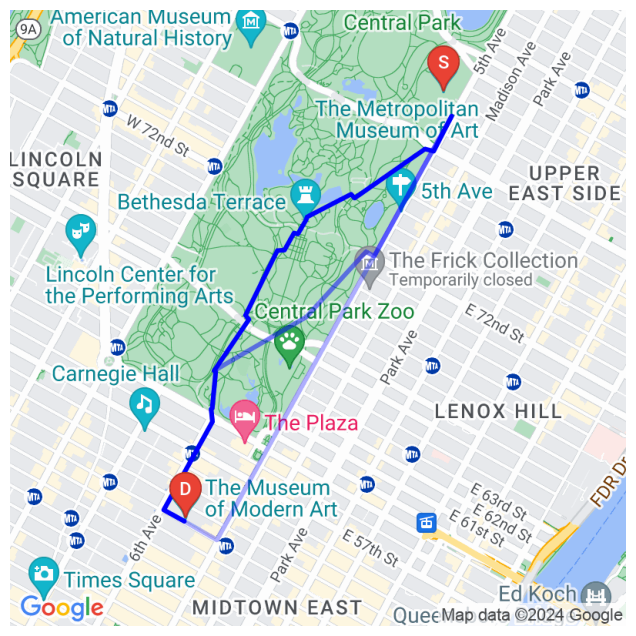

{'0': {'Coordinate': [{'lat': 40.778415, 'long': -73.96283389999999},
   {'lat': 40.7769377, 'long': -73.9638338},
   {'lat': 40.77703160000001, 'long': -73.96431319999999},
   {'lat': 40.7749587, 'long': -73.96823839999999},
   {'lat': 40.7751218, 'long': -73.9684398},
   {'lat': 40.7741625, 'long': -73.97089009999999},
   {'lat': 40.7740486, 'long': -73.970936},
   {'lat': 40.7734449, 'long': -73.971401},
   {'lat': 40.77348569999999, 'long': -73.97161899999999},
   {'lat': 40.7727641, 'long': -73.97214939999999},
   {'lat': 40.7727416, 'long': -73.9725486},
   {'lat': 40.7700118, 'long': -73.97432289999999},
   {'lat': 40.7698335, 'long': -73.974133},
   {'lat': 40.7676716, 'long': -73.9760682},
   {'lat': 40.7676316, 'long': -73.9759821},
   {'lat': 40.7660851, 'long': -73.9761771},
   {'lat': 40.7660465, 'long': -73.97623829999999},
   {'lat': 40.7655217, 'long': -73.9761631},
   {'lat': 40.7617962, 'long': -73.978878},
   {'lat': 40.7613185, 'long': -73.97773529999999}],
  'dista

In [22]:
# Make the API request to get royes
source_address = "Metropolitan Museum of Art"
destination_address = "Museum of Modern Art"

routes = get_routes_and_display_map(source_address, destination_address)
routes

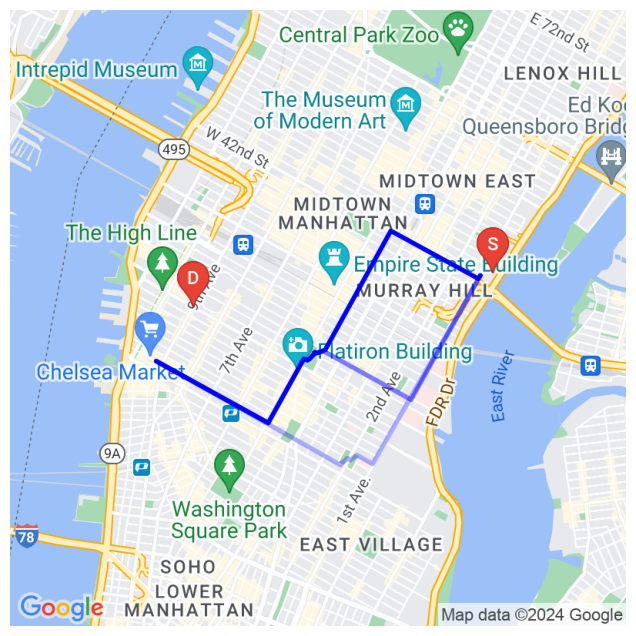

{'0': {'Coordinate': [{'lat': 40.7491896, 'long': -73.9693738},
   {'lat': 40.7489116, 'long': -73.9695821},
   {'lat': 40.7529535, 'long': -73.97935149999999},
   {'lat': 40.7428867, 'long': -73.9866807},
   {'lat': 40.7428912, 'long': -73.98669190000001},
   {'lat': 40.7426347, 'long': -73.9876409},
   {'lat': 40.7427052, 'long': -73.9878193},
   {'lat': 40.7426576, 'long': -73.9879024},
   {'lat': 40.74256889999999, 'long': -73.9879026},
   {'lat': 40.7421512, 'long': -73.98840919999999},
   {'lat': 40.7420444, 'long': -73.98862969999999},
   {'lat': 40.7421368, 'long': -73.9890556},
   {'lat': 40.7367333, 'long': -73.99302039999999},
   {'lat': 40.7419563, 'long': -74.0055045}],
  'distance': '2.7 mi',
  'time': '1 hour 2 mins',
  'risk_score': 3.180389925096087},
 '1': {'Coordinate': [{'lat': 40.7491896, 'long': -73.9693738},
   {'lat': 40.7386925, 'long': -73.97709379999999},
   {'lat': 40.742774, 'long': -73.9867854},
   {'lat': 40.7426347, 'long': -73.9876409},
   {'lat': 40.74

In [23]:
source_address = "WTC Cortlandt"
destination_address = "Grand Central"

source_address = "United Nations Headquarters"
destination_address = "Chelsea Market"
routes = get_routes_and_display_map(source_address, destination_address)
routes